In [1]:
import json
from tqdm import tqdm
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp

from s4hci.utils.data_handling import load_adi_data
from s4hci.models.noise import S4Noise
from s4hci.models.planet import S4Planet
from s4hci.utils.adi_tools import combine_residual_stack
from s4hci.utils.masks import construct_round_rfrr_template

from applefy.utils.fake_planets import add_fake_planets
from applefy.utils.file_handling import save_as_fits

## Load the data

In [2]:
print("Loading data ... ", end='')
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data("/fast/mbonse/s4/30_data/EpsEri_0100_C-0656-A.hdf5",
                  data_tag="13_object_final",
                  psf_template_tag="10_psf",
                  para_tag="header_13_object_final/PARANG") 

psf_template_data = np.mean(raw_psf_template_data, axis=0)
print("[DONE]")

Loading data ... [DONE]


## Add a fake planet

In [3]:
config_file = "/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/exp_ID_0117a.json"

In [4]:
with open(config_file) as json_file:
    fake_planet_config = json.load(json_file)

In [5]:
fake_planet_config

{'type': 'TP estimation',
 'flux_ratio': 0.00039810717055349735,
 'separation': 6.300000000000001,
 'planet_position': [59.3, 53.0, 6.300000000000001, 0.0],
 'exp_id': '0117a'}

In [6]:
# prepare the psf_template
template_cut, _ = construct_round_rfrr_template(
    radius=4.0,
    psf_template_in=psf_template_data)

In [7]:
data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=template_cut, #psf_template_data,
    parang=raw_angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

In [8]:
# This noise model was only trained on half of the images
X_train = data_with_fake_planet[0::2]
anlges_train = raw_angles[0::2]
X_test = data_with_fake_planet[1::2]
anlges_test = raw_angles[1::2]

## Load a pre-trained noise model

In [9]:
save_path_final = Path("/fast/mbonse/s4/70_results/02_fine_tuning/implementation_tests/test_model_trained_fp64.pkl")
s4_noise = S4Noise.load(save_path_final)

Creating right reason mask ... [DONE]


## Create one test residual

In [10]:
s4_noise = s4_noise.float()
s4_noise = s4_noise.to(0)

In [11]:
science_data = torch.from_numpy(X_train).float()
science_data = science_data.to(0)

In [12]:
residuals, _ = s4_noise.predict(science_data)

In [13]:
residuals = residuals.cpu().numpy()

In [14]:
residuals -= np.median(residuals, axis=0)

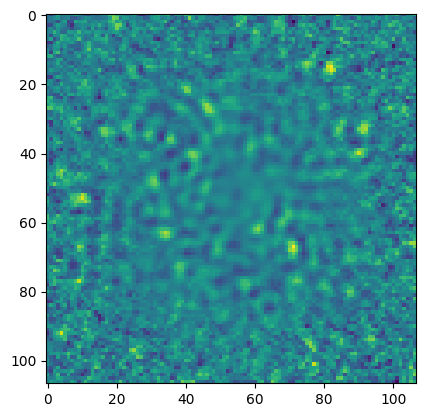

In [15]:
plt.imshow(residuals[17])

In [16]:
results = combine_residual_stack(
    residual_stack=residuals,
    angles=anlges_train,
    combine=["Median_Residuals",],
    suffix="",
    num_cpus=8)

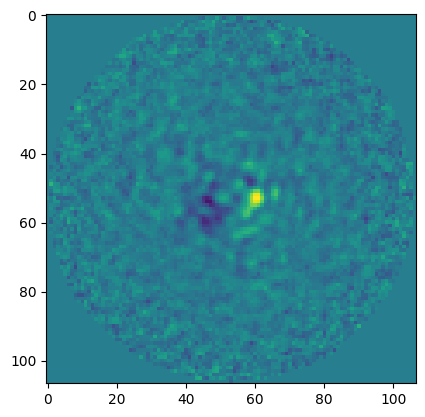

In [17]:
# residual on training data
plt.imshow(results["Median_Residuals"],
           vmin=-0.03, vmax=0.04)

In [18]:
save_as_fits(results["Median_Residuals"], "residual_117a_no_planet_model.fits")

OSError: File residual_117a_no_planet_model.fits already exists. If you mean to replace it then use the argument "overwrite=True".

## Implement the fine-tuning

In [18]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage.transform import rescale

from s4hci.models.rotation import FieldRotationModel
from s4hci.utils.masks import construct_planet_mask


class S4Planet(nn.Module):

    def __init__(
            self,
            data_image_size,
            psf_template,
            # used for the inner radius of the planet mask
            inner_mask_radius=0,
            use_up_sample=1):

        super(S4Planet, self).__init__()

        # 1.) Prepare the PSF template
        psf_model_scaled = rescale(psf_template,
                                   use_up_sample,
                                   preserve_range=True)

        # the psf template is not trainable but also send to the gpu.
        self.register_buffer(
            "psf_model",
            torch.from_numpy(psf_model_scaled).unsqueeze(0).unsqueeze(0).float()
        )

        self.output_size = data_image_size
        self.input_size = int(data_image_size * use_up_sample)
        self.inner_mask_radius = inner_mask_radius

        # 2.) Init the planet model
        # values equal to zero can cause numerical instability
        self.planet_model = nn.Parameter(
            #torch.randn(1,
            #           self.input_size,
            #           self.input_size).float()* 0.00001,
            torch.ones(1,
                       self.input_size,
                       self.input_size).float() * 0.00001,
            requires_grad=True)

        # 3.) Set up the planet mask
        planet_mask = construct_planet_mask(
            self.input_size,
            int(inner_mask_radius * use_up_sample))  # inner region mask

        # the mask is not trainable but also send to the gpu.
        self.register_buffer(
            "planet_mask",
            torch.from_numpy(planet_mask).unsqueeze(0).float())

        # 4.) There are several member variables which are set during training.
        # We initialize them here with None
        # 4.1 ) rotation grid for the training data
        self.rotation = None

    def save(self, file_path):
        state_dict = self.state_dict()

        # add the other information we want to keep
        state_dict["use_up_sample"] = self.use_up_sample
        state_dict["output_size"] = self.output_size
        state_dict["inner_mask_radius"] = self.inner_mask_radius

        torch.save(state_dict, file_path)

    @classmethod
    def load(cls, file_path):
        state_dict = torch.load(file_path)

        # create a dummy psf template
        psf_size = state_dict["psf_model"].shape[-1]
        dummy_template = np.ones((psf_size, psf_size))

        obj = cls(
            data_image_size=state_dict.pop('output_size'),
            psf_template=dummy_template,
            inner_mask_radius=state_dict.pop('inner_mask_radius'),
            use_up_sample=state_dict.pop('use_up_sample'))

        obj.load_state_dict(state_dict)

        return obj

    def setup_for_training(
            self,
            all_angles,
            rotation_grid_down_sample,
            upload_rotation_grid=False):

        # Build the rotation grid for the training data
        # we have to rotate into the opposite direction
        self.rotation = FieldRotationModel(
            all_angles,
            input_size=self.input_size,
            inverse=True,
            subsample=rotation_grid_down_sample,
            register_grid=upload_rotation_grid)

    @property
    def planet_parameters(self):
        return self.planet_model **2

    def get_planet_signal(self):
        planet_signal = F.conv2d(
            self.planet_parameters.unsqueeze(0),
            self.psf_model,
            padding="same")

        # mask circular pattern
        masked_planet_signal = planet_signal.squeeze(0) * self.planet_mask
        
#        masked_planet_signal - torch.median(masked_planet_signal)
        return masked_planet_signal

    def forward(self,
                parang_idx=None,
                new_angles=None):

        if new_angles is not None:
            num_copies = len(new_angles)
        else:
            num_copies = len(parang_idx)

        # 1.) Get the current planet signal and repeat it
        raw_planet_signal = self.get_planet_signal()

        # create stack of planet frames
        planet_stack = raw_planet_signal.repeat(num_copies, 1, 1).clone()

        # 2.) Rotate the planet frames
        output_dim = (self.output_size,
                      self.output_size)

        planet_stack = self.rotation(
            planet_stack.unsqueeze(1),
            parang_idx=parang_idx,
            new_angles=new_angles,
            output_dimensions=output_dim)

        return planet_stack


In [19]:
science_train_torch = torch.from_numpy(X_train).float().to(0)
anlges_train = anlges_train

## Test how P and n(P) look like

In [20]:
import torch
from torch import nn
from torch import optim

In [21]:
# prepare the psf_template
template_cut, _ = construct_round_rfrr_template(
    radius=4.0,
    psf_template_in=psf_template_data)

template_norm = template_cut# / np.max(np.abs(template_cut))

In [22]:
# Create a planet model
s4_planet_model = S4Planet(
    data_image_size=X_train.shape[-1],
    psf_template=template_norm,
    inner_mask_radius=0,
    use_up_sample=1)

In [23]:
# setup planet model for training
s4_planet_model.setup_for_training(
    all_angles=anlges_train,
    rotation_grid_down_sample=10,
    upload_rotation_grid=True)

In [24]:
s4_planet_model = s4_planet_model.to(0)
test_idx = torch.from_numpy(np.arange(science_train_torch.shape[0]))
s4_noise.betas_raw.requires_grad = False

In [195]:
# Normalize the data
science_norm = s4_noise.normalize_data(science_train_torch)

# reshape the science data
science_norm_flatten = science_norm.view(
    science_norm.shape[0], -1)

optimizer = optim.Adam(
    [#s4_noise.betas_raw,
     s4_planet_model.planet_model,],
    lr=1e-3)#,  # 1e-1
#    momentum=0.9)

## test

In [25]:
# build a second noise model for the planet
save_path_final = Path("/fast/mbonse/s4/70_results/02_fine_tuning/implementation_tests/test_model_trained_fp64.pkl")
s4_noise_planet = S4Noise.load(save_path_final)


s4_noise_planet = s4_noise_planet.float()
s4_noise_planet = s4_noise_planet.to(0)

Creating right reason mask ... [DONE]


In [26]:
s4_noise_planet.betas_raw.requires_grad = False

In [27]:
from s4hci.utils.masks import construct_round_rfrr_template, construct_rfrr_mask

right_reason_mask = construct_rfrr_mask(
            template_setup=("radius", 8),
            psf_template_in=s4_noise_planet.psf_model[0,0].cpu().numpy(),
            mask_size_in=s4_noise_planet.image_size)

In [28]:
s4_noise_planet.right_reason_mask.data = torch.tensor(right_reason_mask).float().to(0)

In [30]:
# Normalize the data
science_norm = s4_noise.normalize_data(science_train_torch)

# reshape the science data
science_norm_flatten = science_norm.view(
    science_norm.shape[0], -1)

# compute the noise estimate
# 1.) Compute Beta
s4_noise.compute_betas()

with torch.no_grad():
    noise_estimate = s4_noise(science_norm_flatten)

In [31]:


optimizer = optim.Adam(
    [#s4_noise.betas_raw,
     s4_planet_model.planet_model,],
    lr=1e-3)#,  # 1e-1
#    momentum=0.9)

  1%|█▋                                                                                                                                                                     | 1/100 [00:01<02:34,  1.56s/it]

0.34536758065223694


  2%|███▎                                                                                                                                                                   | 2/100 [00:02<02:08,  1.31s/it]

0.3454723358154297


  3%|█████                                                                                                                                                                  | 3/100 [00:04<02:08,  1.33s/it]

0.3453674912452698


  4%|██████▋                                                                                                                                                                | 4/100 [00:05<02:01,  1.27s/it]

0.3454001843929291


  5%|████████▎                                                                                                                                                              | 5/100 [00:06<01:57,  1.24s/it]

0.34545043110847473


  6%|██████████                                                                                                                                                             | 6/100 [00:07<01:52,  1.19s/it]

0.34539544582366943


  7%|███████████▋                                                                                                                                                           | 7/100 [00:08<01:49,  1.18s/it]

0.34537002444267273


  8%|█████████████▎                                                                                                                                                         | 8/100 [00:10<01:53,  1.23s/it]

0.3453690707683563


  9%|███████████████                                                                                                                                                        | 9/100 [00:11<01:48,  1.20s/it]

0.3453766405582428
0.34538620710372925


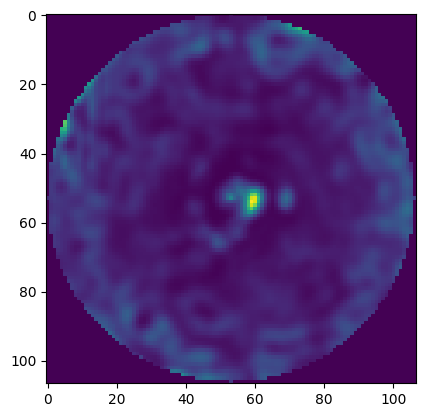

 11%|██████████████████▎                                                                                                                                                   | 11/100 [00:14<02:06,  1.42s/it]

0.345386266708374


 12%|███████████████████▉                                                                                                                                                  | 12/100 [00:15<01:56,  1.32s/it]

0.34537801146507263


 13%|█████████████████████▌                                                                                                                                                | 13/100 [00:16<01:49,  1.26s/it]

0.3453705608844757


 14%|███████████████████████▏                                                                                                                                              | 14/100 [00:17<01:47,  1.25s/it]

0.3453671336174011


 15%|████████████████████████▉                                                                                                                                             | 15/100 [00:19<01:45,  1.24s/it]

0.34536656737327576


 16%|██████████████████████████▌                                                                                                                                           | 16/100 [00:20<01:42,  1.21s/it]

0.3453676700592041


 17%|████████████████████████████▏                                                                                                                                         | 17/100 [00:21<01:39,  1.20s/it]

0.34536921977996826


 18%|█████████████████████████████▉                                                                                                                                        | 18/100 [00:22<01:36,  1.17s/it]

0.34536999464035034


 19%|███████████████████████████████▌                                                                                                                                      | 19/100 [00:23<01:33,  1.16s/it]

0.34536921977996826
0.34536758065223694


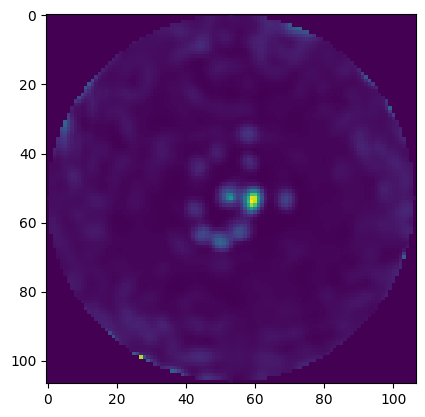

 21%|██████████████████████████████████▊                                                                                                                                   | 21/100 [00:26<01:40,  1.27s/it]

0.3453660011291504


 22%|████████████████████████████████████▌                                                                                                                                 | 22/100 [00:27<01:35,  1.22s/it]

0.34536492824554443


 23%|██████████████████████████████████████▏                                                                                                                               | 23/100 [00:28<01:31,  1.19s/it]

0.3453643023967743


 24%|███████████████████████████████████████▊                                                                                                                              | 24/100 [00:29<01:30,  1.19s/it]

0.3453640341758728


 25%|█████████████████████████████████████████▌                                                                                                                            | 25/100 [00:31<01:27,  1.16s/it]

0.3453640341758728
0.34536415338516235

 26%|███████████████████████████████████████████▏                                                                                                                          | 26/100 [00:32<01:26,  1.16s/it]

 27%|████████████████████████████████████████████▊                                                                                                                         | 27/100 [00:33<01:25,  1.17s/it]

0.3453642427921295


 28%|██████████████████████████████████████████████▍                                                                                                                       | 28/100 [00:34<01:28,  1.23s/it]

0.3453642427921295


 29%|████████████████████████████████████████████████▏                                                                                                                     | 29/100 [00:35<01:26,  1.22s/it]

0.3453640639781952
0.3453638255596161


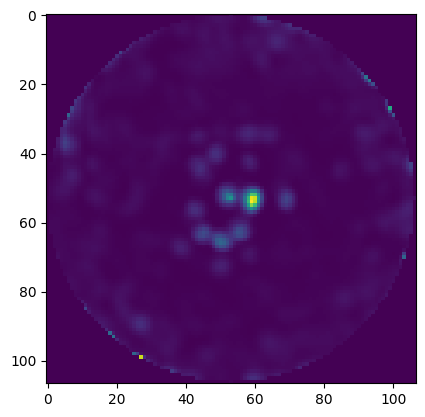

 31%|███████████████████████████████████████████████████▍                                                                                                                  | 31/100 [00:38<01:24,  1.23s/it]

0.3453635573387146
0.3453632593154907

 32%|█████████████████████████████████████████████████████                                                                                                                 | 32/100 [00:39<01:23,  1.23s/it]

 33%|██████████████████████████████████████████████████████▊                                                                                                               | 33/100 [00:40<01:21,  1.21s/it]

0.3453630208969116


 34%|████████████████████████████████████████████████████████▍                                                                                                             | 34/100 [00:42<01:20,  1.23s/it]

0.3453628718852997
0.34536272287368774


 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 36/100 [00:44<01:15,  1.17s/it]

0.34536269307136536


 37%|█████████████████████████████████████████████████████████████▍                                                                                                        | 37/100 [00:45<01:14,  1.18s/it]

0.3453626036643982


 38%|███████████████████████████████████████████████████████████████                                                                                                       | 38/100 [00:46<01:12,  1.16s/it]

0.3453625738620758


 39%|████████████████████████████████████████████████████████████████▋                                                                                                     | 39/100 [00:47<01:10,  1.15s/it]

0.3453625440597534
0.34536248445510864


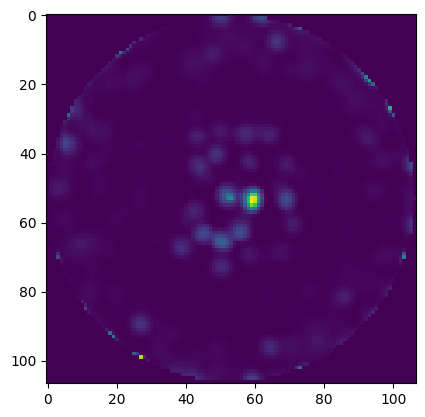

 41%|████████████████████████████████████████████████████████████████████                                                                                                  | 41/100 [00:50<01:13,  1.25s/it]

0.34536245465278625


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 42/100 [00:51<01:10,  1.21s/it]

0.34536242485046387


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 43/100 [00:52<01:06,  1.17s/it]

0.3453623652458191


 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 44/100 [00:53<01:04,  1.16s/it]

0.3453623056411743


 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 45/100 [00:55<01:02,  1.14s/it]

0.3453623056411743


 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 46/100 [00:56<01:02,  1.16s/it]

0.34536221623420715
0.34536221623420715


 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 48/100 [00:58<01:00,  1.16s/it]

0.34536212682724


 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 49/100 [00:59<00:58,  1.14s/it]

0.34536212682724
0.3453620374202728


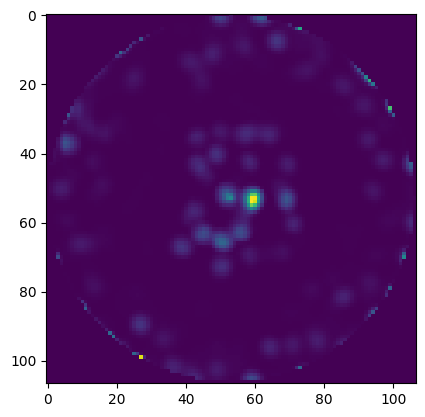

 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 51/100 [01:02<00:59,  1.22s/it]

0.3453620374202728


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 52/100 [01:03<00:58,  1.21s/it]

0.3453620374202728


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 53/100 [01:04<00:55,  1.18s/it]

0.34536200761795044
0.34536197781562805

 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 54/100 [01:05<00:54,  1.17s/it]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 55/100 [01:06<00:52,  1.17s/it]

0.34536197781562805


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 56/100 [01:08<00:50,  1.15s/it]

0.34536197781562805


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 57/100 [01:09<00:48,  1.14s/it]

0.34536197781562805


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 58/100 [01:10<00:47,  1.13s/it]

0.3453619182109833


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 59/100 [01:11<00:47,  1.16s/it]

0.3453618884086609
0.3453618884086609


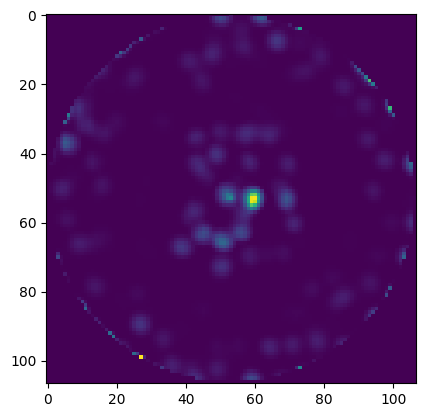

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 61/100 [01:14<00:46,  1.20s/it]

0.3453618884086609


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 62/100 [01:15<00:44,  1.17s/it]

0.3453618884086609


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 63/100 [01:16<00:42,  1.15s/it]

0.3453618884086609


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 64/100 [01:17<00:41,  1.15s/it]

0.3453618884086609


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 65/100 [01:18<00:40,  1.16s/it]

0.3453618884086609


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 66/100 [01:19<00:38,  1.14s/it]

0.3453618586063385


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 67/100 [01:20<00:37,  1.13s/it]

0.3453618884086609


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 68/100 [01:21<00:35,  1.12s/it]

0.3453618586063385


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 69/100 [01:23<00:35,  1.14s/it]

0.3453618586063385
0.3453618586063385


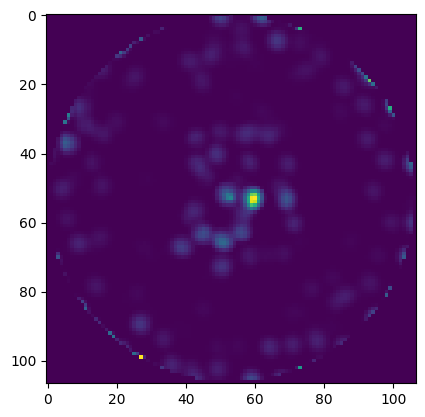

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 71/100 [01:25<00:34,  1.19s/it]

0.3453617990016937


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 72/100 [01:26<00:32,  1.16s/it]

0.3453618586063385


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 73/100 [01:27<00:30,  1.14s/it]

0.3453617990016937
0.3453617990016937

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 74/100 [01:28<00:29,  1.14s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 75/100 [01:30<00:28,  1.14s/it]

0.3453617990016937


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 76/100 [01:31<00:27,  1.13s/it]

0.3453617990016937


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 77/100 [01:32<00:25,  1.12s/it]

0.3453617990016937


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 78/100 [01:33<00:24,  1.11s/it]

0.3453617990016937


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 79/100 [01:34<00:23,  1.12s/it]

0.3453617990016937
0.3453617990016937


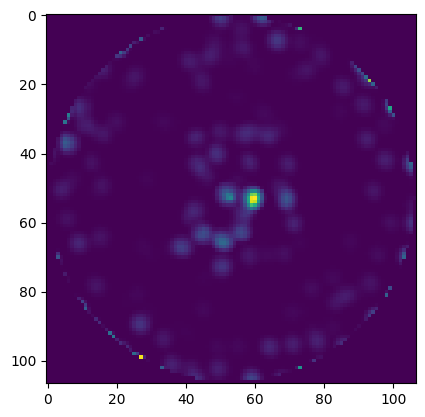

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 81/100 [01:37<00:22,  1.18s/it]

0.3453617990016937
0.3453617990016937


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 83/100 [01:39<00:20,  1.18s/it]

0.3453617990016937


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 84/100 [01:40<00:18,  1.15s/it]

0.3453617990016937


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 85/100 [01:41<00:17,  1.14s/it]

0.3453617990016937


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 86/100 [01:42<00:15,  1.13s/it]

0.3453617990016937


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 87/100 [01:43<00:14,  1.12s/it]

0.3453617990016937


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 88/100 [01:44<00:13,  1.13s/it]

0.3453617990016937


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 89/100 [01:46<00:12,  1.16s/it]

0.3453617990016937
0.3453617990016937


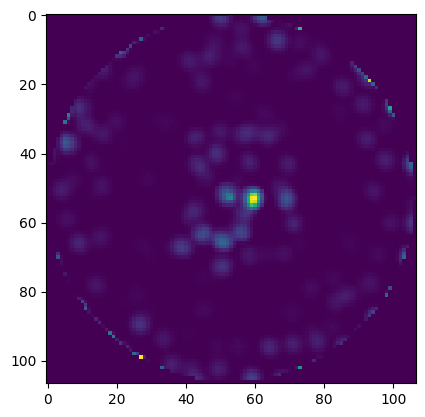

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 91/100 [01:48<00:10,  1.18s/it]

0.3453617990016937


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 92/100 [01:49<00:09,  1.16s/it]

0.3453617990016937


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 93/100 [01:50<00:07,  1.14s/it]

0.3453617990016937
0.3453617990016937


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 95/100 [01:52<00:05,  1.11s/it]

0.3453617990016937


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 96/100 [01:54<00:04,  1.11s/it]

0.3453617990016937


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 97/100 [01:55<00:03,  1.13s/it]

0.3453617990016937


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 98/100 [01:56<00:02,  1.12s/it]

0.3453617990016937


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 99/100 [01:57<00:01,  1.12s/it]

0.3453617990016937
0.3453617990016937


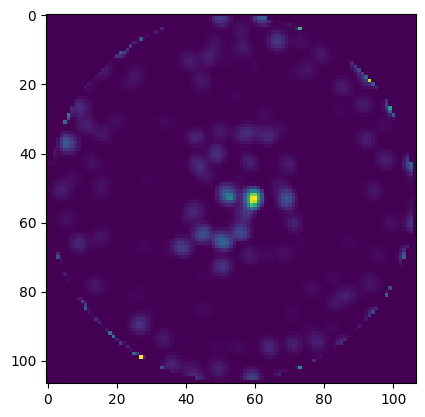

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


In [32]:
losses_recon = []
losses_reg = []

for epoch in tqdm(range(100)):
    optimizer.zero_grad(set_to_none=True)
        
    # 2.) run forward for the planet model
    planet_signal = s4_planet_model.forward(test_idx)
    planet_signal_norm = planet_signal / s4_noise.std_frame
    
    planet_signal = planet_signal.view(science_norm.shape[0], -1)
    planet_signal_norm = planet_signal_norm.view(science_norm.shape[0], -1)
    
   
    # compute n(P)
    n_p = s4_noise_planet(planet_signal_norm)
    

    # 4.) estimate the modeled data
    modeled_data = noise_estimate + planet_signal_norm - n_p
    
    # 4.) Compute the loss       
    loss_recon = ((modeled_data - science_norm_flatten)**2).mean()
    #loss_reg = (s4_noise.betas_raw**2).mean()
    #loss_planet = (s4_planet_model.planet_model.abs()).mean()
    #loss_planet = ((noise_planet * planet_signal_norm)**2).mean()

    # 5.) Normalize the loss
    loss_normalization = 1.
    loss_recon /= loss_normalization
    #loss_reg /= loss_normalization
    #loss_planet /= loss_normalization


    # 6.) Backward 
    loss = loss_recon #+ loss_planet *1e5# + loss_reg * s4_noise.lambda_reg * lambda_factor)
    loss.backward()#retain_graph=True)

    optimizer.step()

    # 7.) Print the loss terms
    losses_recon.append(loss_recon.item())
    #losses_reg.append(loss_reg.item())
    print(loss_recon.item())
    #print(loss_planet.item())
    
    if epoch % 10 == 9:
        # plot the planet signal
        with torch.no_grad():
            tmp_norm_signal = s4_planet_model.get_planet_signal() / s4_noise.std_frame
            plt.imshow(tmp_norm_signal.cpu().numpy()[0])
            plt.show()

## Check the terms

In [33]:
# 1.) Compute Beta
s4_noise.compute_betas()

planet_signal = s4_planet_model.forward(test_idx)

planet_signal_norm = planet_signal / s4_noise.std_frame
planet_signal_norm = planet_signal_norm.view(science_norm.shape[0], -1)

# 3.) run forward for the noise
noise_planet = s4_noise(planet_signal_norm)

In [34]:
noise_planet_stack = noise_planet.view(
    science_norm.shape[0], 
    s4_noise.image_size,
    s4_noise.image_size).detach().cpu().numpy()

planet_stack = planet_signal_norm.view(
    science_norm.shape[0], 
    s4_noise.image_size,
    s4_noise.image_size).detach().cpu().numpy()

In [35]:
noise_planet_combined = combine_residual_stack(
    residual_stack=noise_planet_stack,
    angles=anlges_train,
    combine=["Median_Residuals",],
    suffix="",
    num_cpus=8)

planet_combined = combine_residual_stack(
    residual_stack=planet_stack,
    angles=anlges_train,
    combine=["Median_Residuals",],
    suffix="",
    num_cpus=8)

In [36]:
#save_as_fits(planet_combined["Median_Residuals"], "planet_model_117a_no_loss.fits")
#save_as_fits(noise_planet_combined["Median_Residuals"], "noise_planet_model_117a_no_loss.fits")

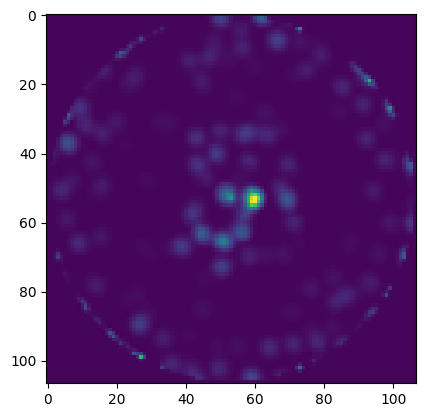

In [37]:
# residual on training data
plt.imshow(planet_combined["Median_Residuals"])

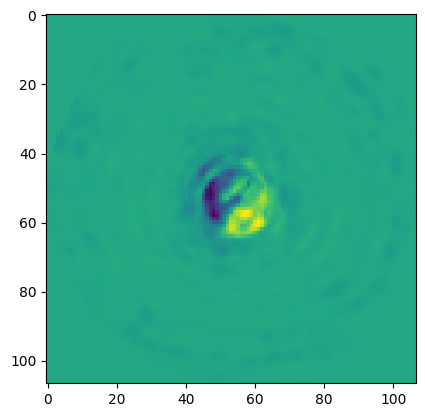

In [38]:
# residual on training data
test_image = noise_planet_combined["Median_Residuals"]
#test_image[test_image < 0] =0
plt.imshow(-test_image)

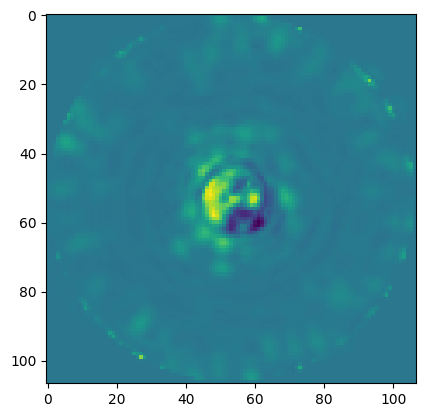

In [39]:
# residual on training data
plt.imshow(planet_combined["Median_Residuals"] + noise_planet_combined["Median_Residuals"])

In [40]:
# 1.) Compute Beta
s4_noise.compute_betas()

planet_signal = s4_planet_model.forward(test_idx)

planet_signal_norm = planet_signal / s4_noise.std_frame
planet_signal_norm = planet_signal_norm.view(science_norm.shape[0], -1)

if True:
    tmp_science_in = science_norm_flatten - planet_signal_norm
else:
    tmp_science_in = science_norm_flatten


# 3.) run forward for the noise
noise_estimate = s4_noise(tmp_science_in)

In [41]:
# compute the residual
residuals = science_norm_flatten - noise_estimate
residual_stack = residuals.view(
    science_norm.shape[0], 
    s4_noise.image_size,
    s4_noise.image_size).detach().cpu().numpy()

In [42]:
residual_stack -= np.median(residual_stack, axis=0)

In [43]:
results = combine_residual_stack(
    residual_stack=residual_stack,
    angles=anlges_train,
    combine=["Median_Residuals",],
    suffix="",
    num_cpus=8)

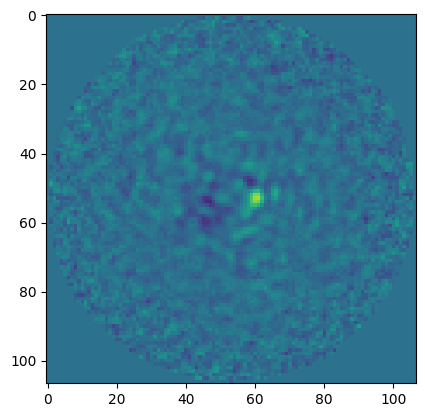

In [44]:
# residual on training data
plt.imshow(results["Median_Residuals"],
           vmin=-0.03, vmax=0.05)

In [42]:
save_as_fits(results["Median_Residuals"], "residual_117a_with_planet_no_loss.fits")